In [1]:
import requests
import re
import json
from urllib import parse
import time
import jieba
from matplotlib import pyplot as plt
from PIL import Image
import wordcloud
from collections import Counter
import pymongo
%matplotlib inline

In [3]:
def getHtml(url):
    headers = {
        'Cookie': 'pgv_pvid=3918504627; pac_uid=0_fa38b19827a7c; tvfe_boss_uuid=322f64b84f1316ee; AMCV_248F210755B762187F000101%40AdobeOrg=-1891778711%7CMCIDTS%7C18008%7CMCMID%7C73888650160712395190870001653859710530%7CMCAAMLH-1556491252%7C7%7CMCAAMB-1556491252%7CRKhpRz8krg2tLO6pguXWp5olkAcUniQYPHaMWWgdJ3xzPWQmdj0y%7CMCOPTOUT-1555893652s%7CNONE%7CMCAID%7CNONE%7CvVersion%7C2.4.0; eas_sid=J195E5F6S3d9I7o8e0x0u8e6C1; pgv_pvi=6811439104; LW_uid=R1N5A586H6b6N312d2C6K8S2y7; LW_sid=x1i5J6k1z423d7U8K0x088K5Y5; pgv_pvid_new=10001_a15a30a72e; pgv_info=ssid=s2570261392; g_tk=9903965324cc4e41cbc68072c05317837a28fcf2; __guid=2209186.3545395084861666300.1564272793405.6245; monitor_count=3; ad_play_index=12; ts_last=coral.qq.com/4031994449; ts_uid=3381523565',
        'Host': 'coral.qq.com',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.80 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    response.encoding = response.apparent_encoding
    return response

In [4]:
def createUrl(cursor = 0):
    baseUrl = 'http://coral.qq.com/article/4031994449/comment/v2?'
    params = {
            'callback':'_article4031994449commentv2',
            'orinum':10,
            'oriorder':'o',
            'pageflag':1,
            'cursor':cursor,
            'scorecursor':0,
            'orirepnum':2,
            'reporder':'o',
            'reppageflag':1,
            'source':1,
            '_':int(time.time() * 1000)
    }
    Url = baseUrl + parse.urlencode(params)
    return Url

In [5]:
def getPage():
    url = 'http://coral.qq.com/article/4031994449/commentnum?'
    params = {
            'callback':'_article4031994449commentnum',
            '_':int(time.time() * 1000)
    }
    Url = url + parse.urlencode(params)
    response = getHtml(Url).text
    inner = response.split('(')[-1].split(')')[0]
    number = int(json.loads(inner)['data']['commentnum'])
    pages = number // 10 + 1
    return pages 

In [6]:
def amend(string):
    return re.sub('<.*?>', '', string)

In [ ]:
maxPage = getPage()
cursor = 0
Comments = []
Times = []
Approves = []
Replys = []
UserIds = []
for i in range(maxPage):
    Url = createUrl(cursor=cursor)
    respo = getHtml(Url).text
    respos = re.sub(u"\t|\n|\.|-|;|\)|\(|\?|'|", '', ''.join(''.join(respo.split('(')[1:]).split(')')[:-1]))
    json_data = json.loads(respos)['data']
    if len(json_data) == 0:
        break
    Comments.extend([amend(each['content']) for each in json_data['oriCommList']])
    Times.extend([time.strftime("%Y/%m/%d %H:%M", time.localtime(int(each['time'])))  for each in json_data['oriCommList']])
    Approves.extend([int(each['up'])  for each in json_data['oriCommList']])
    Replys.extend([int(each['orireplynum'])  for each in json_data['oriCommList']])
    UserIds.extend([int(each['userid'])  for each in json_data['oriCommList']])
    cursor = json_data['oriCommList'][-1]['id']

In [8]:
def dataSaveMongoDB(data, databaseName, collectionName, allIn = True):
    '''
    data: [{}, {}, {}]
    '''
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[databaseName]
    collection = db[collectionName]
    
    if allIn:
        collection.insert_many(data)
    else:
        for each in data:
            collection.insert_one(each)

    print('Save successfully!')

    
data = []
for comm, tim, appro, reply, user in zip(Comments, Times, Approves, Replys, UserIds):
    data.append({"Time":tim, "Comment":comm, "Reply":reply, "Approval":appro, "UserId": user})

dataSaveMongoDB(data, "TencentComment", "QuanZhiGaoShou")

Save successfully!


In [9]:
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

stopwords = stopwordslist('stop_list_CN.txt')

In [10]:
final = []
for single in Comments:
    outer = ''
    word_lists = jieba.lcut(single)
    for each in word_lists:
        if each not in stopwords:
            final.append(each.strip())
final = [each for each in final if len(each) > 0]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Fred\AppData\Local\Temp\jieba.cache
Loading model cost 0.815 seconds.
Prefix dict has been built succesfully.


(-0.5, 297.5, 296.5, -0.5)

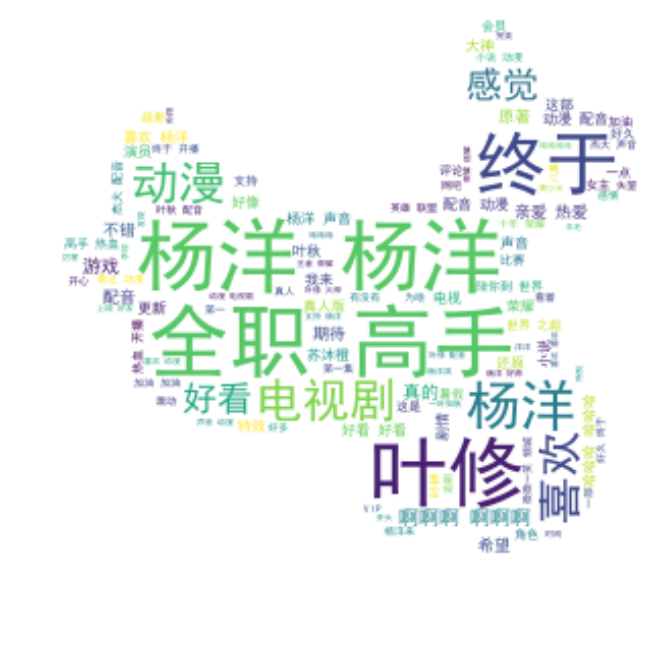

In [12]:
masks = np.array(Image.open('./China.png'))
wc = wordcloud.WordCloud(font_path = 'C:/Windows/Fonts/SimHei.ttf', background_color="white", max_words=200,
                max_font_size=40, random_state=42, mask = masks)
wc.generate(' '.join(final))

fig = plt.figure(figsize = (10,8), dpi = 100)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')